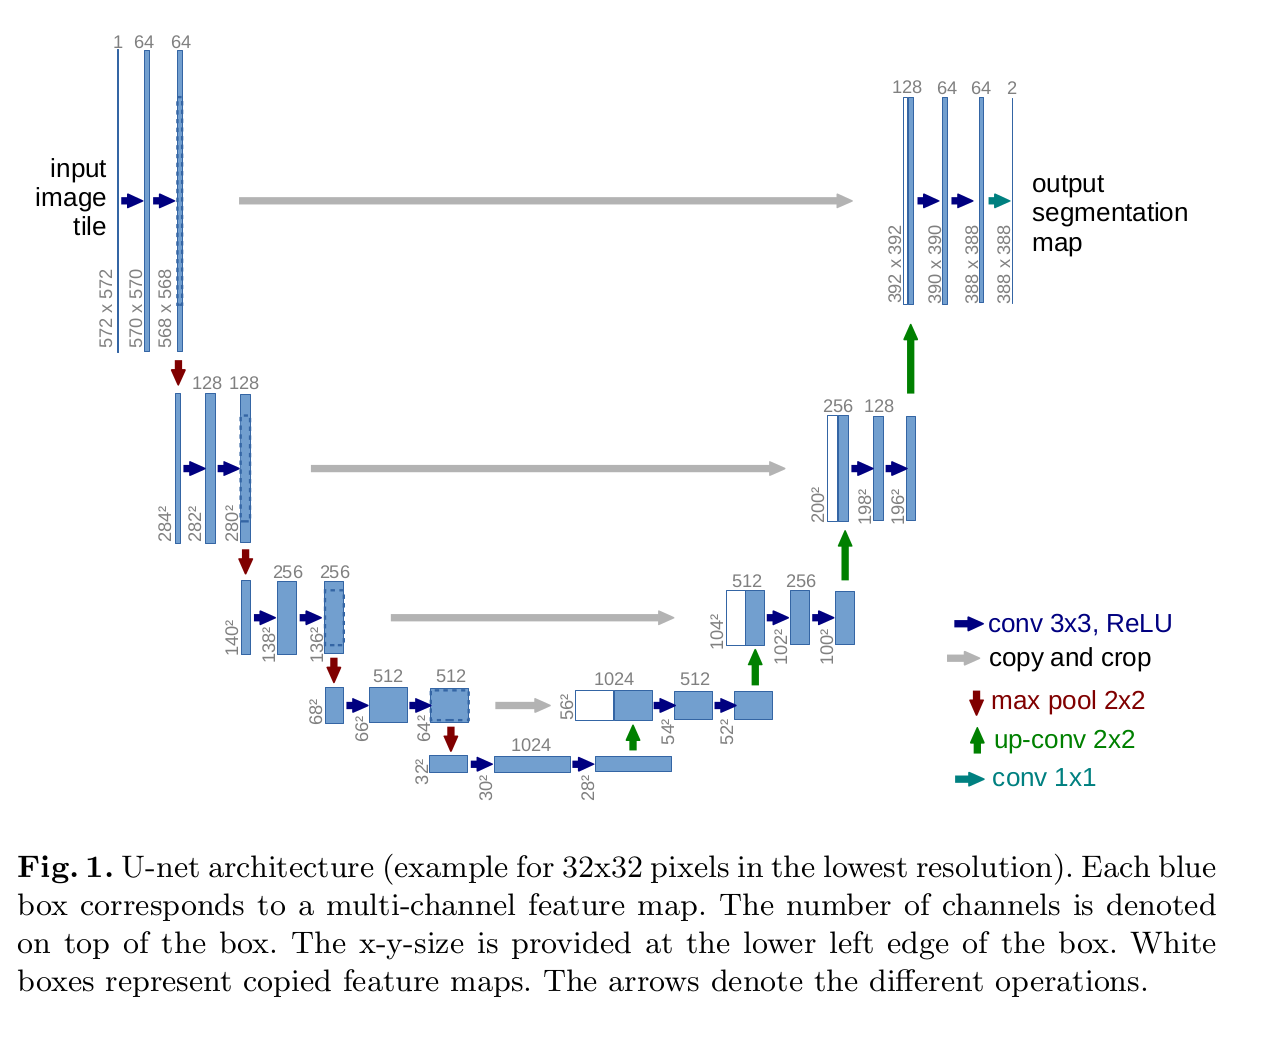

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

In [2]:
import torch
import torch.nn as nn

In [3]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv

In [4]:
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

In [80]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, image):
        # batch_size, channel, height, width
        # encoder
        x1 = self.down_conv_1(image)  # skip connection
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)     # skip connection
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)     # skip connection
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)     # skip connection
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        
        # decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x = self.out(x)
        
        # print(x.size())
        return x

In [6]:
if __name__ == '__main__':
    image = torch.rand((1, 1, 572, 572))
    model = UNet()
    print(model(image))   # forward pass

tensor([[[[-0.0135, -0.0132, -0.0089,  ..., -0.0064, -0.0095, -0.0110],
          [-0.0119, -0.0148, -0.0115,  ..., -0.0097, -0.0114, -0.0108],
          [-0.0097, -0.0109, -0.0099,  ..., -0.0068, -0.0121, -0.0094],
          ...,
          [-0.0129, -0.0089, -0.0114,  ..., -0.0113, -0.0126, -0.0151],
          [-0.0060, -0.0109, -0.0155,  ..., -0.0087, -0.0075, -0.0126],
          [-0.0116, -0.0088, -0.0118,  ..., -0.0106, -0.0113, -0.0085]],

         [[-0.1415, -0.1370, -0.1384,  ..., -0.1381, -0.1383, -0.1371],
          [-0.1391, -0.1386, -0.1406,  ..., -0.1384, -0.1391, -0.1374],
          [-0.1428, -0.1401, -0.1370,  ..., -0.1365, -0.1419, -0.1392],
          ...,
          [-0.1401, -0.1382, -0.1366,  ..., -0.1387, -0.1388, -0.1396],
          [-0.1329, -0.1372, -0.1379,  ..., -0.1390, -0.1365, -0.1411],
          [-0.1432, -0.1376, -0.1368,  ..., -0.1358, -0.1392, -0.1363]]]],
       grad_fn=<ConvolutionBackward0>)


In [22]:
myimage = cv2.imread('cat.jpg')
# convert image to RGB format because cv2 reads image in BGR format instead of RGB
myimage = cv2.cvtColor(myimage, cv2.COLOR_BGR2RGB) 
myimage.shape

(1199, 1200, 3)

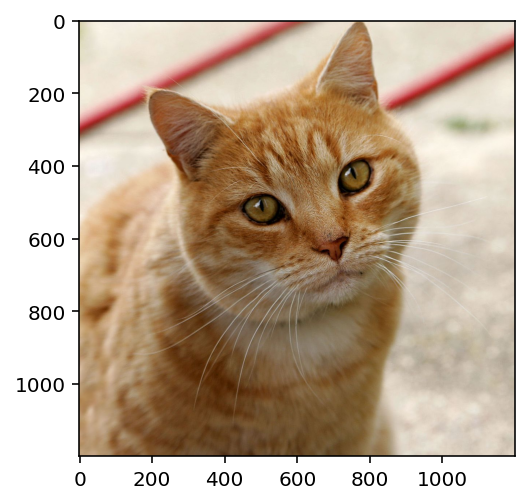

In [24]:
plt.imshow(myimage);

In [33]:
myimage = cv2.imread('cat.jpg')
myimage_gray = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
myimage_gray.shape

(1199, 1200)

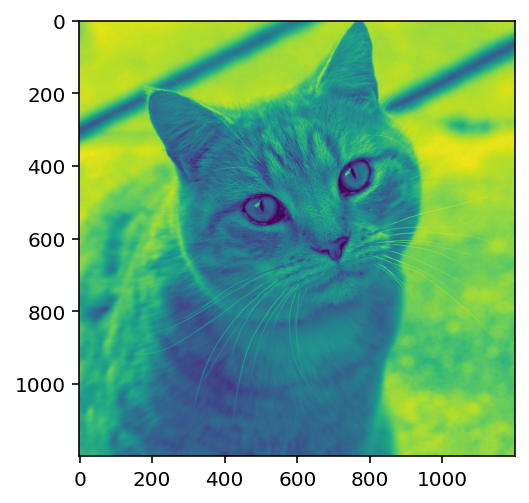

In [34]:
plt.imshow(myimage_gray);

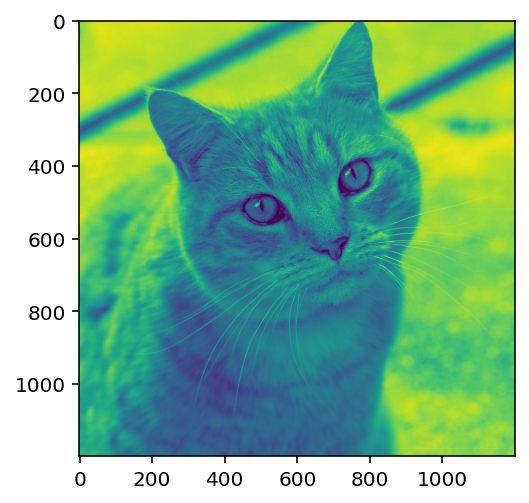

In [32]:
# load image in gray scale
gray = cv2.imread('cat.jpg', 0)
plt.imshow(gray);

In [45]:
# resize the image to match that of our unet's input size requirement
gray2 = cv2.resize(gray, (572, 572))
gray2.shape

(572, 572)

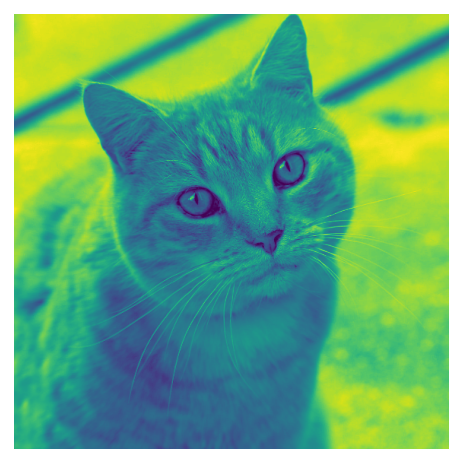

In [46]:
plt.imshow(gray2)
plt.axis('off');

In [21]:
myimage1 = img.imread('cat.jpg')  # img reads image in RGB format 
myimage1.shape

(1199, 1200, 3)

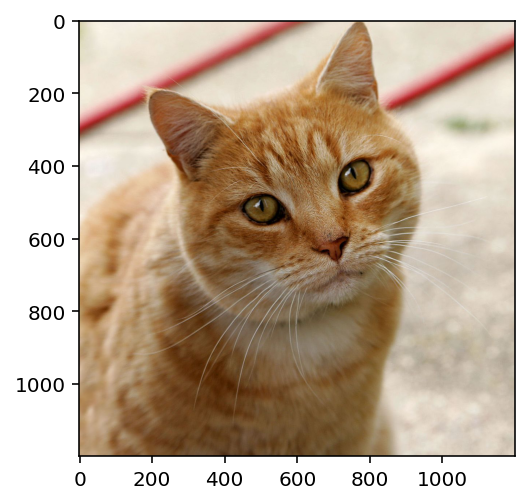

In [16]:
plt.imshow(myimage1);

In [28]:
myimage2 = cv2.cvtColor(myimage1, cv2.COLOR_RGB2GRAY)
myimage2.shape

(1199, 1200)

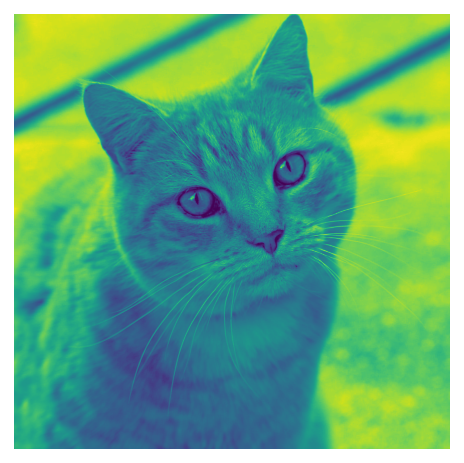

In [30]:
plt.imshow(myimage2)
plt.axis('off');

In [81]:
class UNet2(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, image):
        # batch_size, channel, height, width
        # encoder
        x1 = self.down_conv_1(image)  # skip connection
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)     # skip connection
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)     # skip connection
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)     # skip connection
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        
        # decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x = self.out(x)
        
        # print(x.size())
        return x

In [47]:
# let's send the image in grayscale to our unet
image_tensor = torch.Tensor(gray2)
image_tensor.shape

torch.Size([572, 572])

In [54]:
image_tensor = image_tensor.reshape(1, 1, 572, 572)
# equivalent to -> image_tensor.unsqueeze(0).unsqueeze(0)
image_tensor.shape

torch.Size([1, 1, 572, 572])

In [75]:
model2 = UNet2()
result = model2(image_tensor)
result.shape

torch.Size([1, 1, 388, 388])

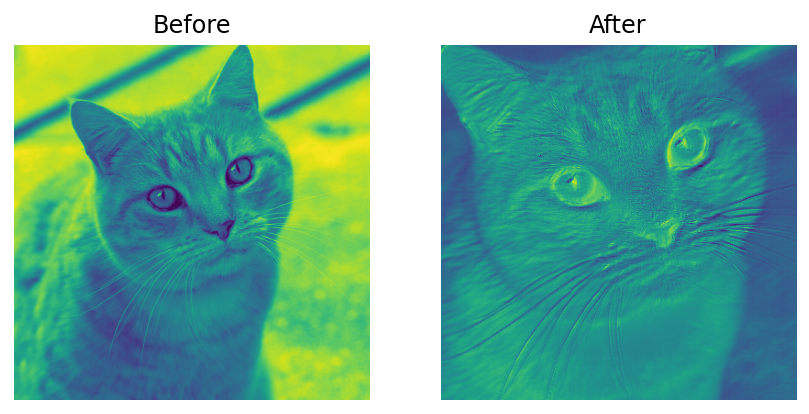

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))

axs[0].imshow(gray2)
axs[0].set_title("Before")
axs[0].axis('off')

result_np = result.detach().numpy()
axs[1].imshow(result_np.reshape(388, 388))
axs[1].set_title("After")
axs[1].axis('off');

**Full U-Net**

In [ ]:
%%writefile unet.py
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv
    
    
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, image):
        # batch_size, channel, height, width
        # encoder
        x1 = self.down_conv_1(image)  # skip connection
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)     # skip connection
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)     # skip connection
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)     # skip connection
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        
        # decoder
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        
        x = self.out(x)
        
        # print(x.size())
        return x
        

if __name__ == '__main__':
    image = torch.rand((1, 1, 572, 572))
    model = UNet()
    print(model(image))   # forward pass